In [9]:
%time 


import geopandas as gpd
from shapely.geometry import Point, polygon, LineString

from shapely.geometry import Point, Polygon, LineString
from shapely import geometry
from shapely.geometry import MultiPolygon, Polygon, LineString, Point, MultiPoint
import IPython.display as display
#import contextily as ctx
#import mplleaflet
#import geoplot.crs as gcrs

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from datetime import datetime
import ipywidgets as widgets
import copy
import warnings
warnings.filterwarnings('ignore')

#from bioinfokit import analys, visuz

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

CPU times: total: 0 ns
Wall time: 0 ns


In [2]:
# éste es un archivo preprocesado con datos de la encuesta
viajes = (pd.read_csv(r'V:\Diplomado Análisis de Datos Espaciales\Módulo 3\Clase 39\eod_santiago_2012.csv')
.assign(departure_time=lambda x: pd.to_timedelta(x['HoraIni']))
.assign(arrival_time=lambda x: pd.to_timedelta(x['HoraFin']))
.assign(trip_duration=lambda x: (x['arrival_time'] - x['departure_time']) / pd.Timedelta(minutes=1))
)
viajes.sample(2)

,Viaje,Hogar,Persona,Etapas,ComunaOrigen,ComunaDestino,SectorOrigen,SectorDestino,ZonaOrigen,ZonaDestino,OrigenCoordX,OrigenCoordY,DestinoCoordX,DestinoCoordY,Proposito,PropositoAgregado,ActividadDestino,MediosUsados,ModoAgregado,ModoPriPub,ModoMotor,HoraIni,HoraFin,HoraMedia,TiempoViaje,TiempoMedio,Periodo,MinutosDespues,CuadrasDespues,FactorLaboralNormal,FactorSabadoNormal,FactorDomingoNormal,FactorLaboralEstival,FactorFindesemanaEstival,CodigoTiempo,ModoDifusion,DistEuclidiana,DistManhattan,Imputada,HoraDeInicio,Sexo,TramoIngreso,Ocupacion,JornadaTrabajo,Relacion,origin_latitude,origin_longitude,destination_latitude,destination_longitude,Sector,Comuna,home_latitude,home_longitude,NumPer,NumVeh,NumBicAdulto,NumBicNino,IngresoHogar,Zona,departure_time,arrival_time,trip_duration
2111,1079410301,107941,10794103,1,Cerro Navia,Cerro Navia,Poniente,Poniente,82,81,338303.5000,6300846.0,337998.9063,6300811.5,Al estudio,2.0,NaN,8,Caminata,5,2,0 days 08:20:00.000000000,0 days 08:30:00.000000000,8:25,10.0,1.0,Punta Mañana 2 (7:31 - 9:00),10.0,5.0,1.143880,NaN,NaN,NaN,NaN,0.0,Caminata,307,339,0,8.333333,Mujer,NaN,NaN,NaN,Hijo o Hija,-33.419571,-70.739105,-33.419836,-70.742386,Poniente,CERRO NAVIA,-33.419571,-70.739105,3,0,0,0,226450,82,0 days 08:20:00,0 days 08:30:00,10.0
61886,2522630302,252263,25226303,2,Providencia,San Bernardo,Oriente,Sur,497,758,350288.1563,6300011.0,341403.1875,6283271.5,volver a casa,2.0,NaN,4;3,Bus TS - Metro,2,1,0 days 17:30:00.000000000,0 days 19:00:00.000000000,18:15,90.0,3.0,Punta Tarde (17:31 - 20:30),15.0,7.0,1.052764,NaN,NaN,NaN,NaN,0.0,Bip!,18951,25624,0,17.500000,Mujer,Menos de 200.000 pesos,NaN,NaN,Otro pariente,-33.428839,-70.610391,-33.578479,-70.708891,Sur,SAN BERNARDO,-33.578480,-70.708891,3,0,0,0,296594,758,0 days 17:30:00,0 days 19:00:00,90.0


In [3]:
# viajes con distancia mayor a 300 metros
viajes = viajes[(viajes.DistManhattan >= 300)
# sacamos las otras actividades (especifique)
& (viajes.Proposito != 'Otra actividad (especifique)')
# estamos analizando la RM así que sacamos viajes fuera de ésta
& (~viajes.SectorOrigen.isin(['Exterior a RM']))
& (~viajes.Sector.isin(['Exterior a RM']))
& (~viajes.SectorDestino.isin(['Exterior a RM']))
# para los modos de viaje, tampoco se indica qué es "otros"
& ~(viajes.ModoDifusion == 'Otros')].copy()

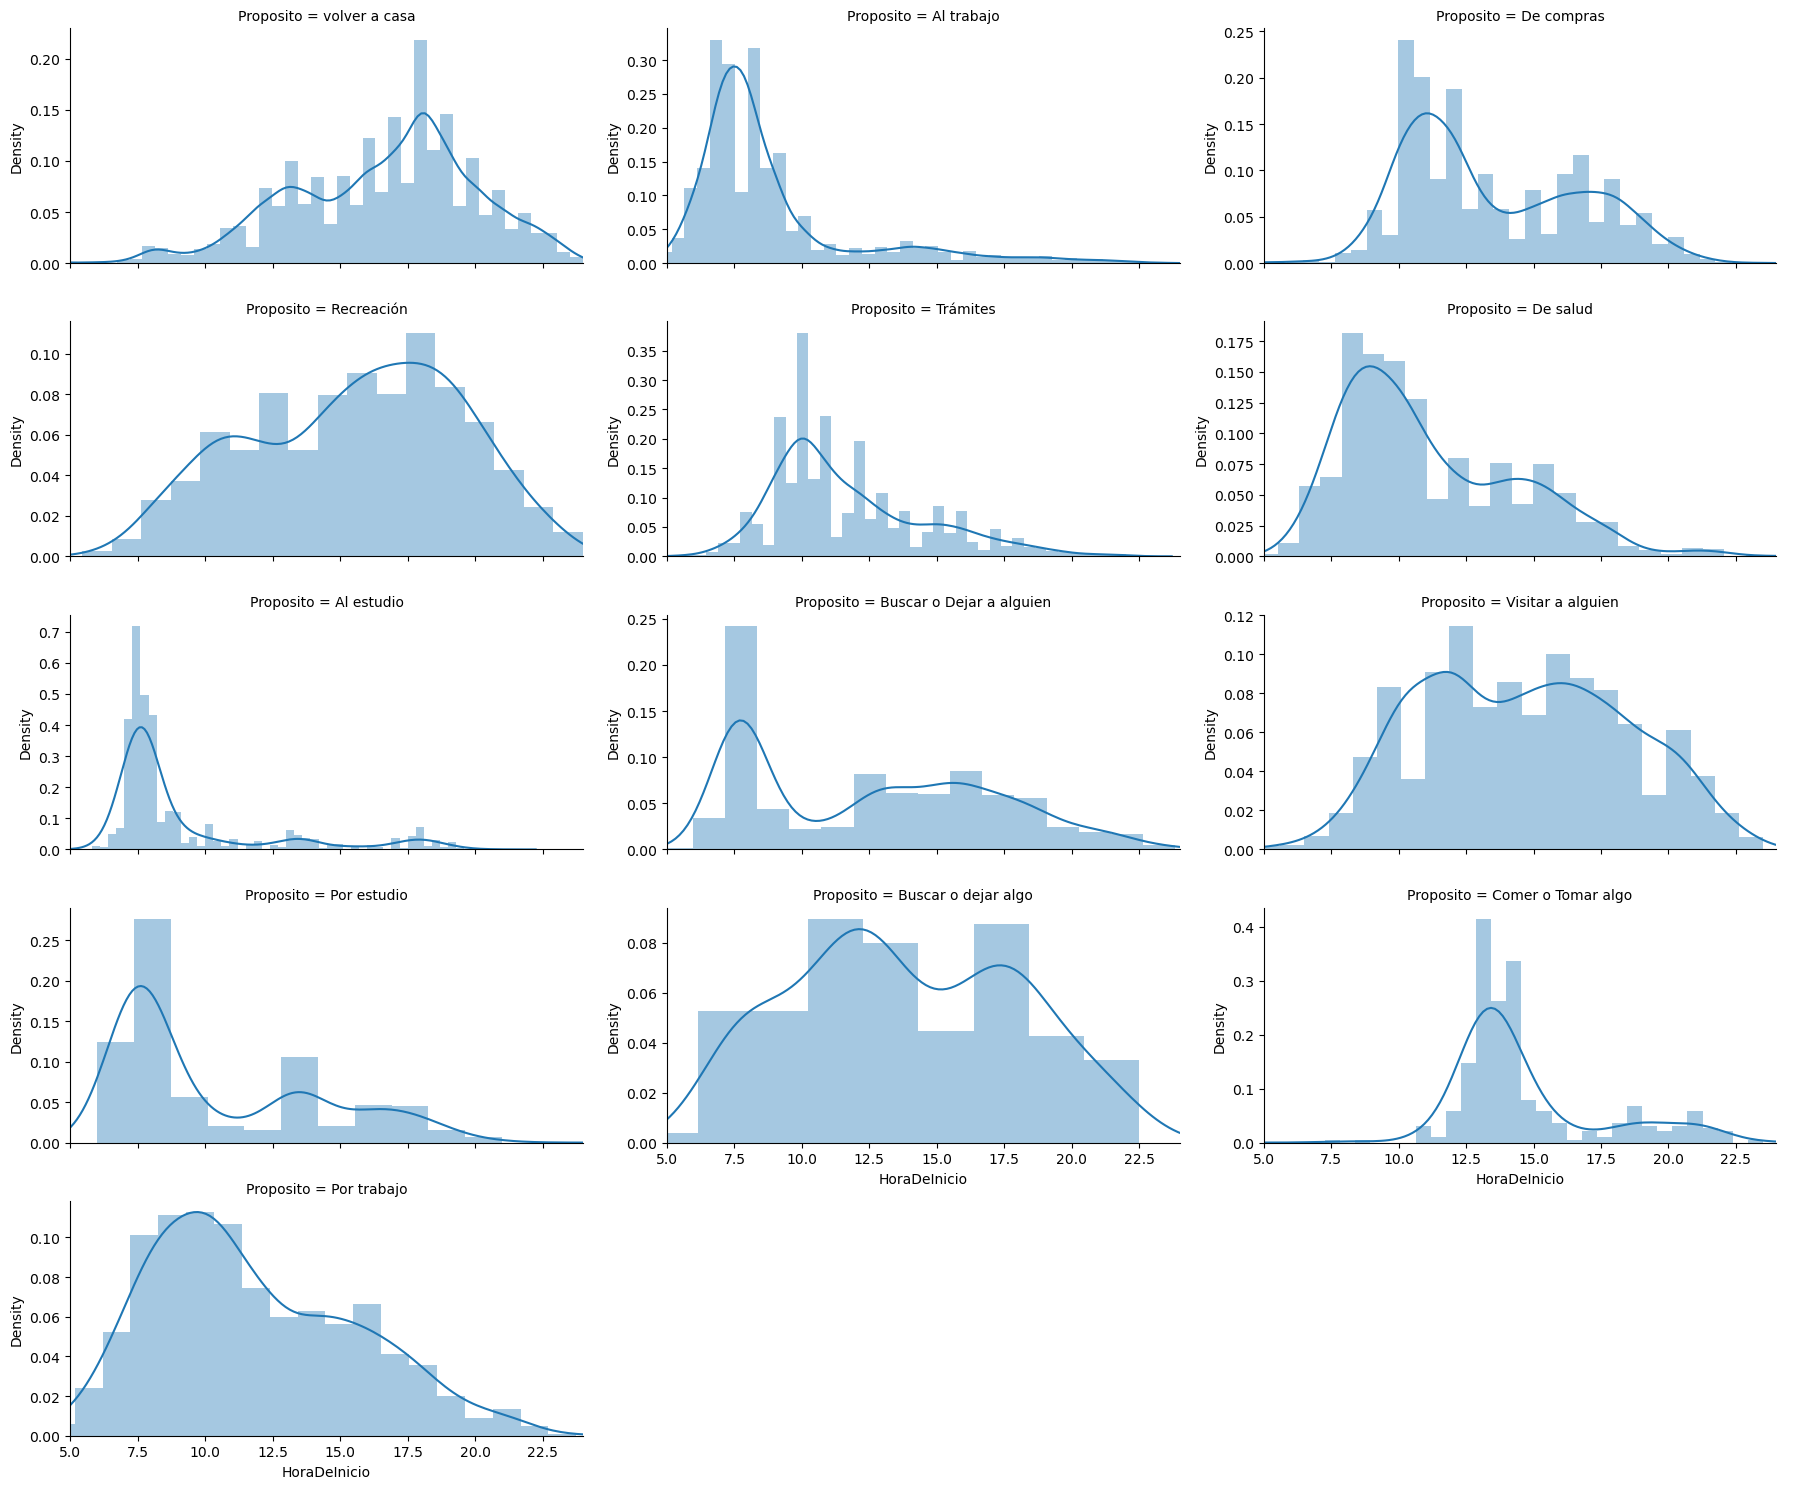

In [5]:
g = sb.FacetGrid(data=viajes, col='Proposito', col_wrap=3, aspect=2, sharey=False)
g.map(sb.distplot, 'HoraDeInicio')
g.add_legend()
g.set(xlim=[5,24])

In [6]:
# viajes con distancia mayor a 300 metros
viajes = viajes[(viajes.DistManhattan >= 300)
# sacamos las otras actividades (especifique)
& (viajes.Proposito != 'Otra actividad (especifique)')
# estamos analizando la RM así que sacamos viajes fuera de ésta
& (~viajes.SectorOrigen.isin(['Exterior a RM']))
& (~viajes.Sector.isin(['Exterior a RM']))
& (~viajes.SectorDestino.isin(['Exterior a RM']))
# para los modos de viaje, tampoco se indica qué es "otros"
& ~(viajes.ModoDifusion == 'Otros')].copy()

In [7]:
viajes.shape, viajes.columns

((66753, 62),
 Index(['Viaje', 'Hogar', 'Persona', 'Etapas', 'ComunaOrigen', 'ComunaDestino',
        'SectorOrigen', 'SectorDestino', 'ZonaOrigen', 'ZonaDestino',
        'OrigenCoordX', 'OrigenCoordY', 'DestinoCoordX', 'DestinoCoordY',
        'Proposito', 'PropositoAgregado', 'ActividadDestino', 'MediosUsados',
        'ModoAgregado', 'ModoPriPub', 'ModoMotor', 'HoraIni', 'HoraFin',
        'HoraMedia', 'TiempoViaje', 'TiempoMedio', 'Periodo', 'MinutosDespues',
        'CuadrasDespues', 'FactorLaboralNormal', 'FactorSabadoNormal',
        'FactorDomingoNormal', 'FactorLaboralEstival',
        'FactorFindesemanaEstival', 'CodigoTiempo', 'ModoDifusion',
        'DistEuclidiana', 'DistManhattan', 'Imputada', 'HoraDeInicio', 'Sexo',
        'TramoIngreso', 'Ocupacion', 'JornadaTrabajo', 'Relacion',
        'origin_latitude', 'origin_longitude', 'destination_latitude',
        'destination_longitude', 'Sector', 'Comuna', 'home_latitude',
        'home_longitude', 'NumPer', 'NumVeh', 'Num

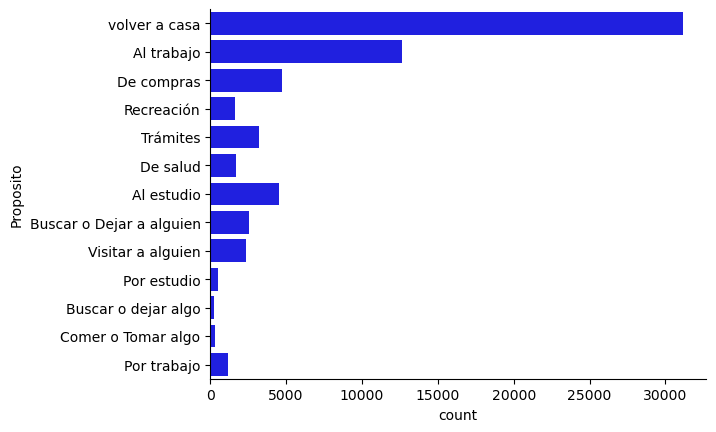

In [10]:
sns.countplot(y='Proposito', data=viajes, color='blue')
sns.despine()

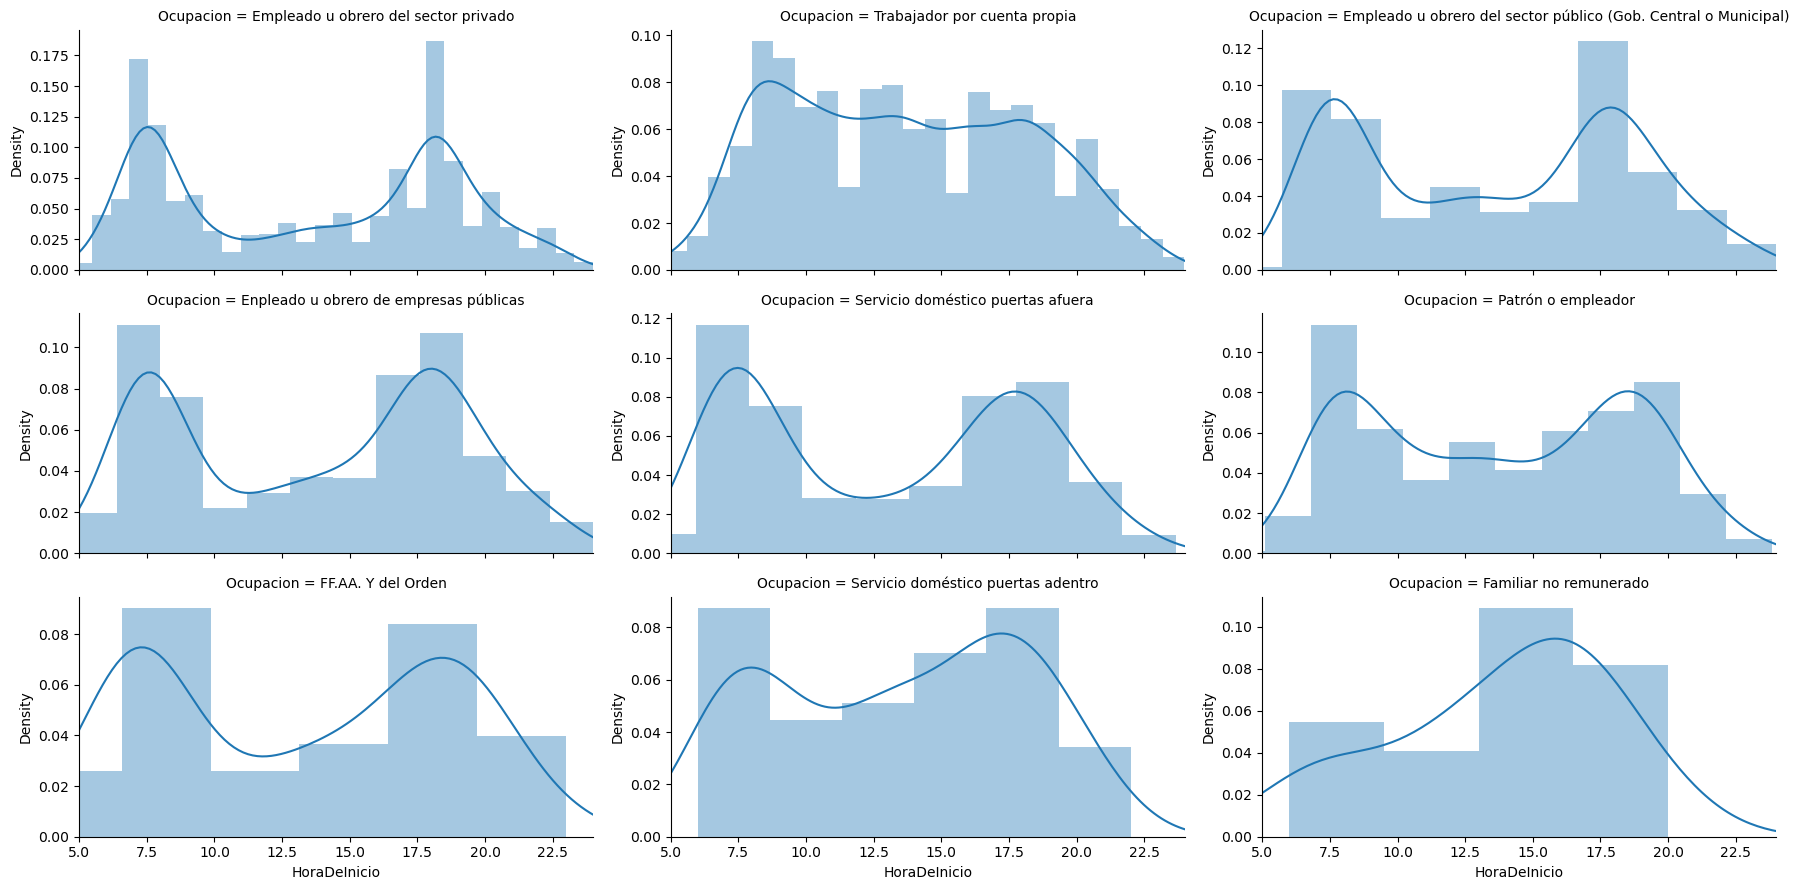

In [11]:
g1 = sns.FacetGrid(data=viajes, col='Ocupacion', col_wrap=3, aspect=2, sharey=False)
g1.map(sns.distplot, 'HoraDeInicio')
g1.add_legend()
g1.set(xlim=[5,24])

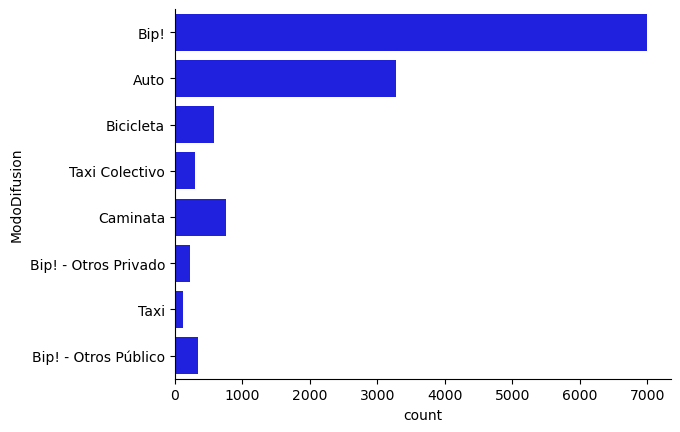

In [12]:
sns.countplot(y='ModoDifusion', data=viajes[viajes.Proposito == 'Al trabajo'],
             color='blue')
sns.despine()

<Axes: xlabel='ModoDifusion', ylabel='Sector'>

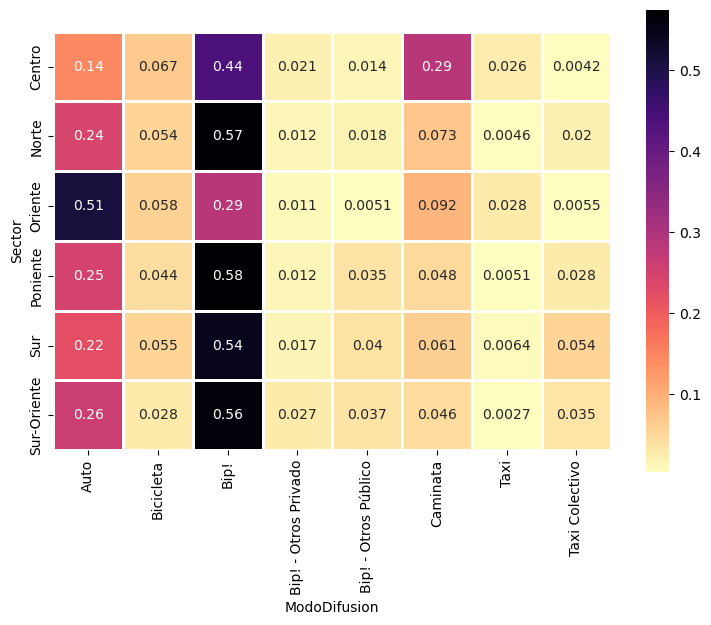

In [13]:
modo = (viajes[viajes.Proposito == 'Al trabajo']
       .groupby(['Sector', 'ModoDifusion'])
       .aggregate({'FactorLaboralNormal': 'sum'})
       .reset_index()
       .pivot_table(index='Sector', values='FactorLaboralNormal', columns='ModoDifusion')
       .pipe(lambda x: x.div(x.sum(axis=1), axis=0))
       )

plt.figure(figsize=(9,6))
sns.heatmap(modo, cmap='magma_r', annot=True, linewidth=1, square=True, robust=True)

<Axes: xlabel='ModoDifusion', ylabel='Comuna'>

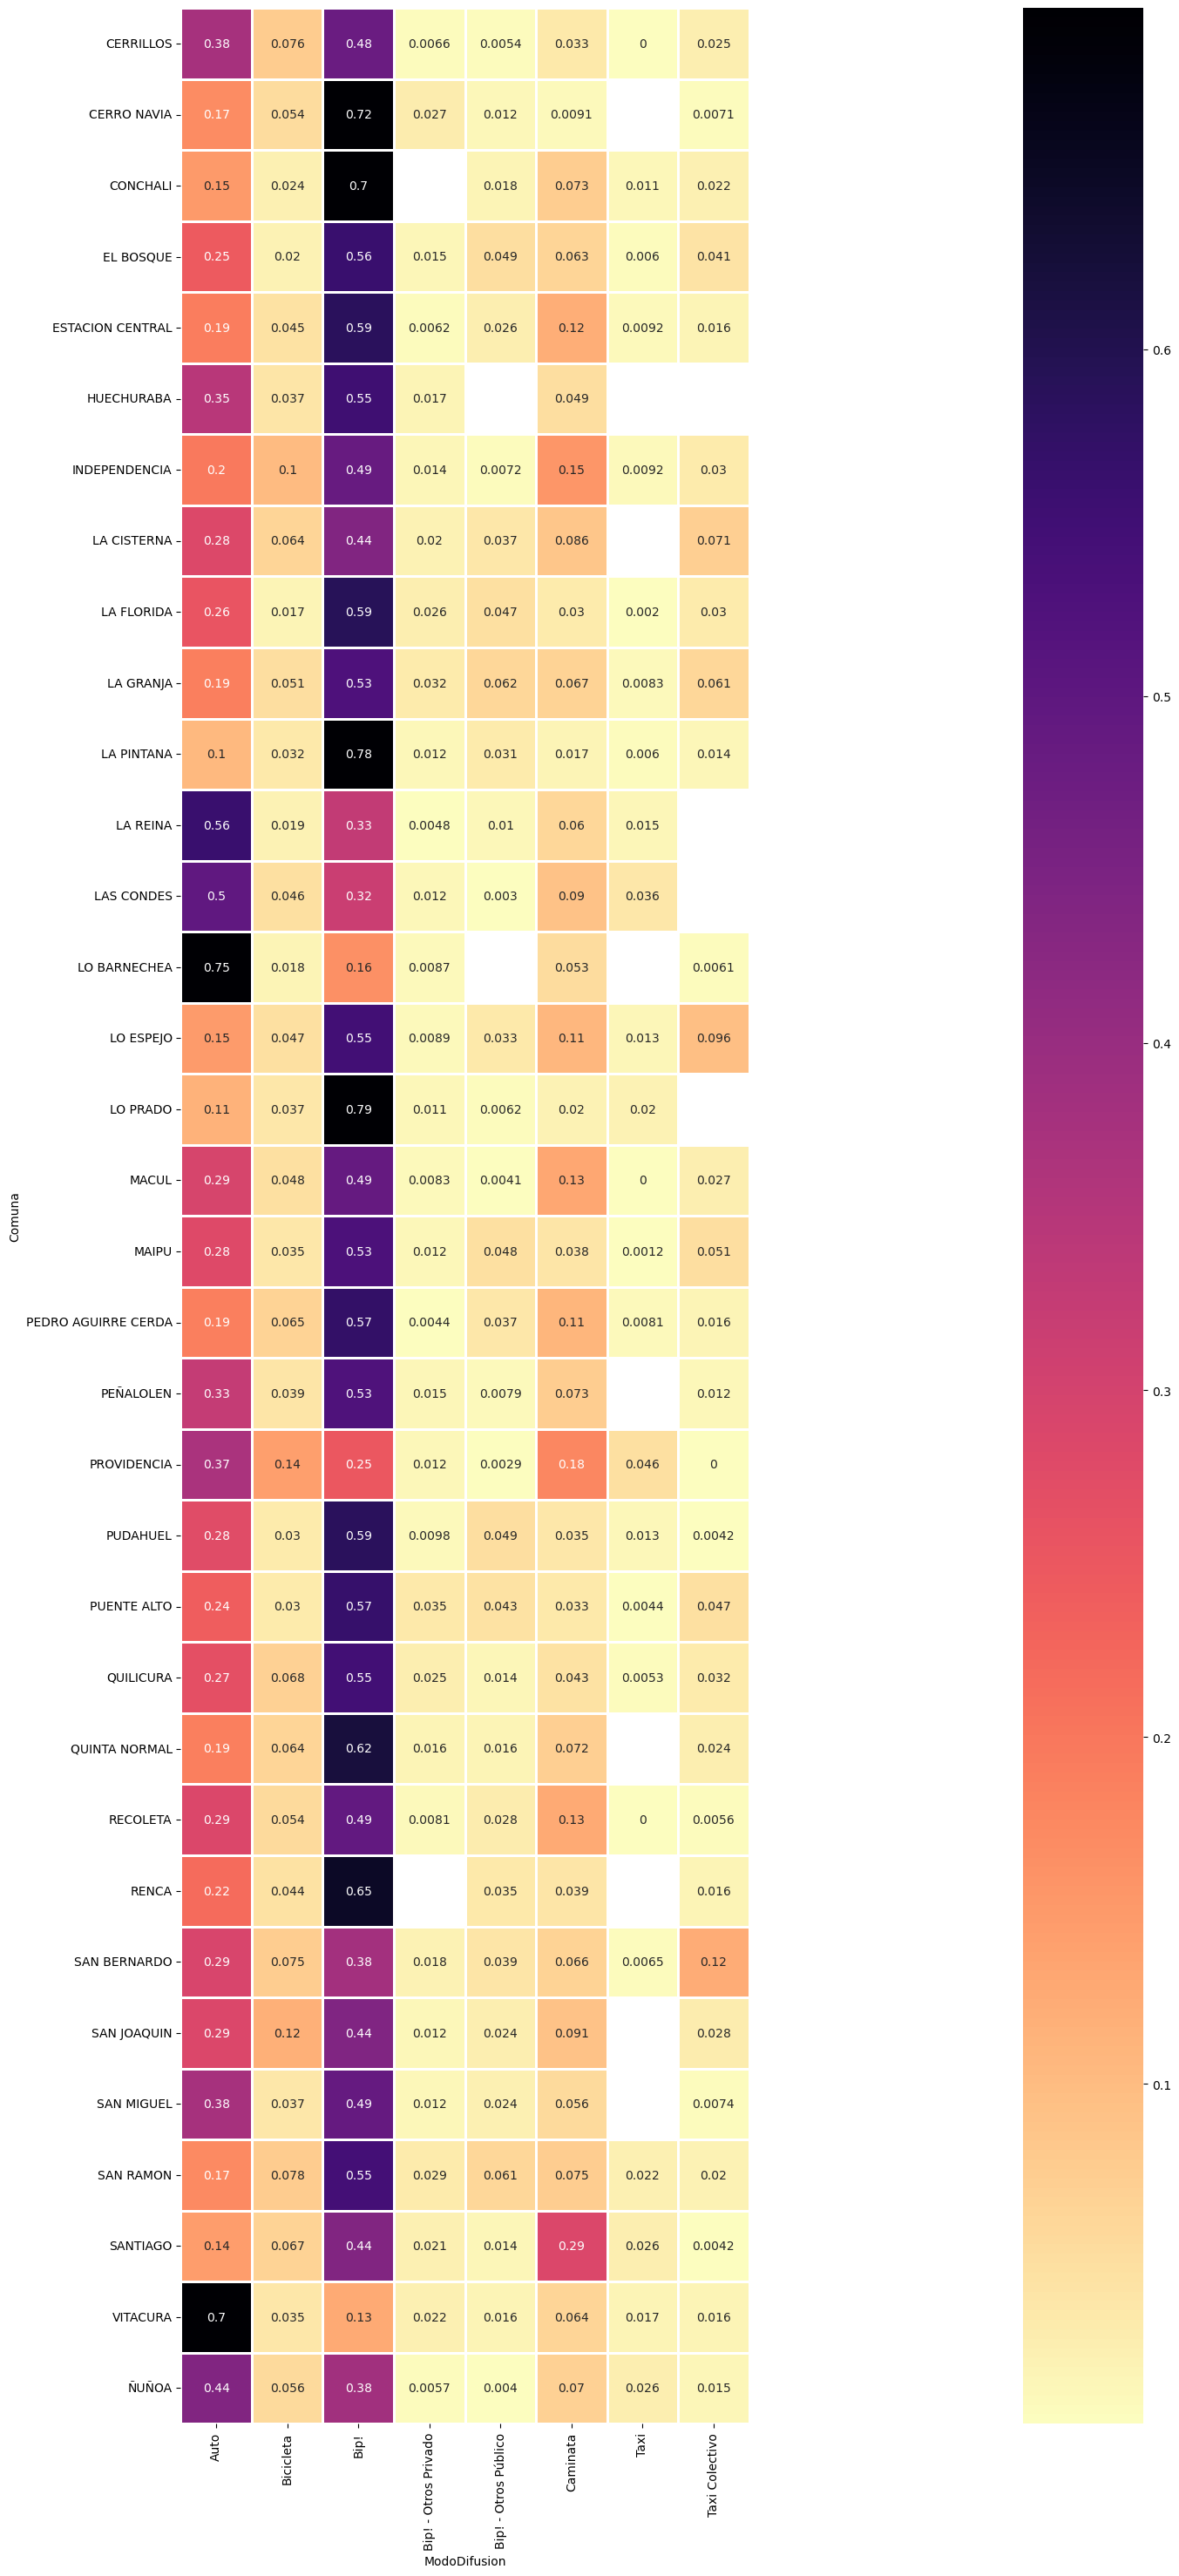

In [14]:
modo = (viajes[viajes.Proposito == 'Al trabajo']
       .groupby(['Comuna', 'ModoDifusion'])
       .aggregate({'FactorLaboralNormal': 'sum'})
       .reset_index()
       .pivot_table(index='Comuna', values='FactorLaboralNormal', columns='ModoDifusion')
       .pipe(lambda x: x.div(x.sum(axis=1), axis=0))
       )

plt.figure(figsize=(81,36))
sns.heatmap(modo, cmap='magma_r', annot=True, linewidth=1, square=True, robust=True)

<Axes: xlabel='Relacion', ylabel='Comuna'>

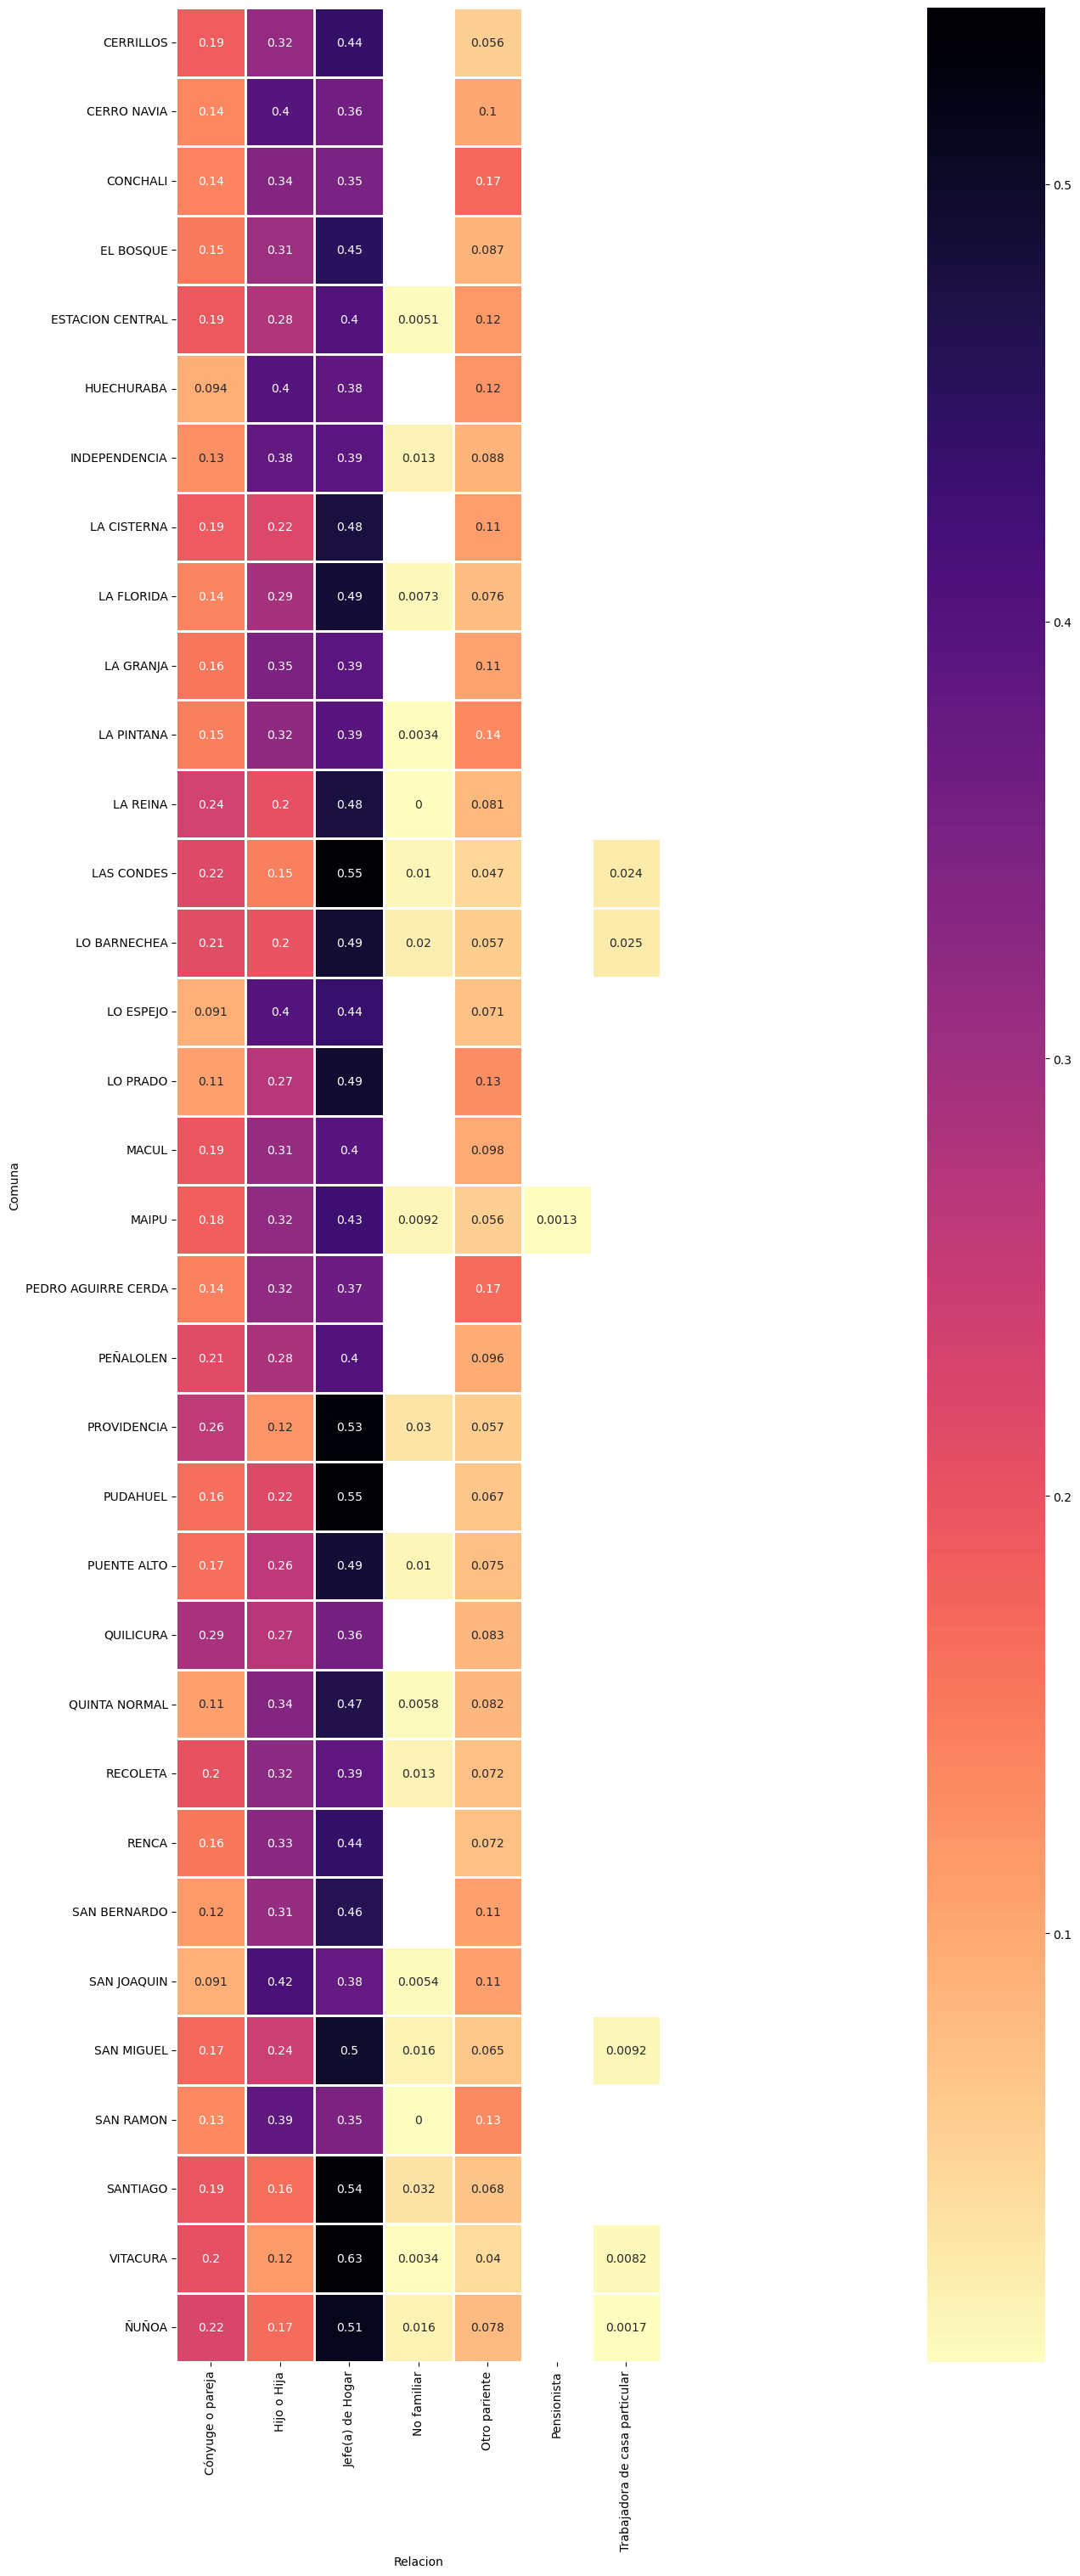

In [18]:
modo1 = (viajes[viajes.Proposito == 'Al trabajo']
       .groupby(['Comuna', 'Relacion'])
       .aggregate({'FactorLaboralNormal': 'sum'})
       .reset_index()
       .pivot_table(index='Comuna', values='FactorLaboralNormal', columns='Relacion')
       .pipe(lambda x: x.div(x.sum(axis=1), axis=0))
       )

plt.figure(figsize=(81,36))
sns.heatmap(modo1, cmap='magma_r', annot=True, linewidth=1, square=True, robust=True)

<Axes: xlabel='ModoDifusion', ylabel='Ocupacion'>

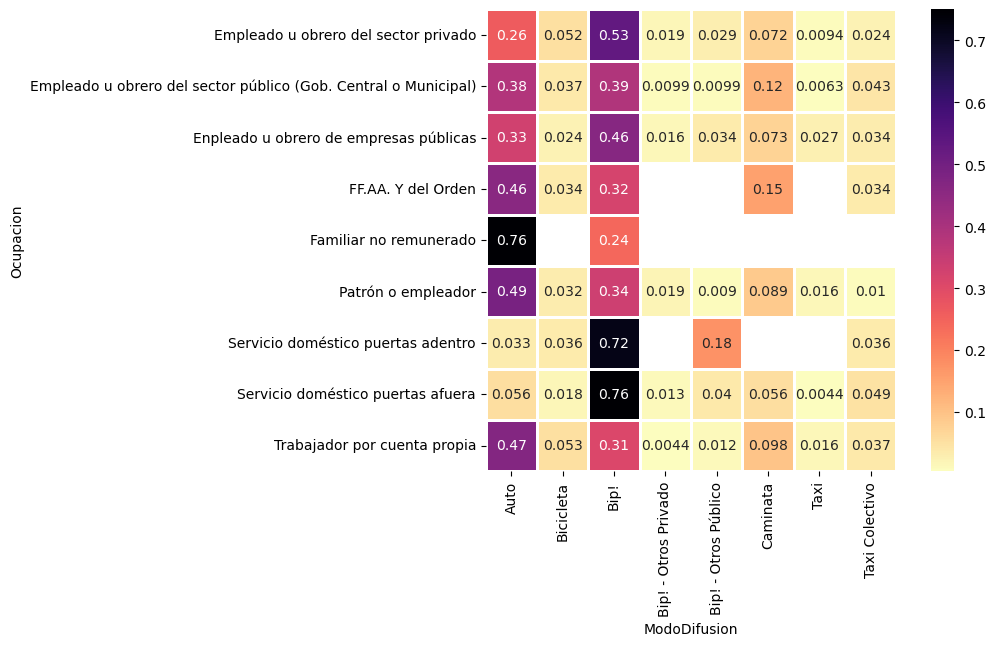

In [21]:
modo4 = (viajes[viajes.Proposito == 'Al trabajo']
       .groupby(['Ocupacion', 'ModoDifusion'])
       .aggregate({'FactorLaboralNormal': 'sum'})
       .reset_index()
       .pivot_table(index='Ocupacion', values='FactorLaboralNormal', columns='ModoDifusion')
       .pipe(lambda x: x.div(x.sum(axis=1), axis=0))
       )

plt.figure(figsize=(9,6))
sns.heatmap(modo4, cmap='magma_r', annot=True, linewidth=1, square=True, robust=True)

In [22]:
zonas = gpd.read_file(r"V:/Diplomado Análisis de Datos Espaciales/Módulo 3/ZONA_C17.shp", encoding = 'UTF-8', sep=',', low_memory=True)
zonas.head(2)

,REGION,NOM_REGION,PROVINCIA,NOM_PROVIN,COMUNA,NOM_COMUNA,URBANO,DISTRITO,LOC_ZON,GEOCODIGO,SHAPE_Leng,SHAPE_Area,geometry
0,13,REGIÓN METROPOLITANA DE SANTIAGO,134,MAIPO,13404,PAINE,PAINE,1,3,13404011003,0.030604,0.000043,"POLYGON ((-70.72732 -33.80301, -70.72713 -33.8..."
1,13,REGIÓN METROPOLITANA DE SANTIAGO,134,MAIPO,13404,PAINE,PAINE,1,2,13404011002,0.045283,0.000071,"POLYGON ((-70.70792 -33.80101, -70.70783 -33.8..."


In [23]:
comunas = zonas.dissolve(by='NOM_COMUNA')
comunas.head(2)

,geometry,REGION,NOM_REGION,PROVINCIA,NOM_PROVIN,COMUNA,URBANO,DISTRITO,LOC_ZON,GEOCODIGO,SHAPE_Leng,SHAPE_Area
NOM_COMUNA,,,,,,,,,,,,
ALHUÉ,"POLYGON ((-71.09853 -34.02734, -71.09753 -34.0...",13,REGIÓN METROPOLITANA DE SANTIAGO,135,MELIPILLA,13502,VILLA ALHUÉ,1,1,13502011001,0.087029,0.000254
BUIN,"MULTIPOLYGON (((-70.85314 -33.80205, -70.85251...",13,REGIÓN METROPOLITANA DE SANTIAGO,134,MAIPO,13402,EL RULO,6,1,13402061001,0.079659,0.000084


In [24]:
viajes.dtypes

Viaje                                 int64
Hogar                                 int64
Persona                               int64
Etapas                                int64
ComunaOrigen                         object
ComunaDestino                        object
SectorOrigen                         object
SectorDestino                        object
ZonaOrigen                            int64
ZonaDestino                           int64
OrigenCoordX                        float64
OrigenCoordY                        float64
DestinoCoordX                       float64
DestinoCoordY                       float64
Proposito                            object
PropositoAgregado                   float64
ActividadDestino                     object
MediosUsados                         object
ModoAgregado                         object
ModoPriPub                            int64
ModoMotor                             int64
HoraIni                              object
HoraFin                         

In [ ]:
modo4 = (viajes[viajes.Proposito == 'Al trabajo']
       .groupby(['Ocupacion', 'ModoDifusion'])
       .aggregate({'FactorLaboralNormal': 'sum'})
       .reset_index()
       .pivot_table(index='Ocupacion', values='FactorLaboralNormal', columns='ModoDifusion')
       .pipe(lambda x: x.div(x.sum(axis=1), axis=0))
       )

plt.figure(figsize=(9,6))
sns.heatmap(modo4, cmap='magma_r', annot=True, linewidth=1, square=True, robust=True)

In [48]:
modo5 = (viajes[viajes.Proposito == 'Al trabajo']
       .groupby(['Comuna', 'ModoDifusion'])
       .aggregate({'FactorLaboralNormal': 'sum'})
       .reset_index()
       .pivot_table(index='Comuna', values='FactorLaboralNormal', columns='ModoDifusion')
       .pipe(lambda x: x.div(x.sum(axis=1), axis=0))
       )

In [52]:
modo5 = modo5.rename(columns={'NOM_COMUNA':'Comuna'})

In [63]:


viajes_shp = comunas.merge(modo5, left_on='NOM_COMUNA', right_on='Comuna', how='inner')
print(viajes_shp)

                                             geometry REGION  \
0   POLYGON ((-70.73432 -33.51008, -70.73433 -33.5...     13   
1   POLYGON ((-70.73772 -33.43644, -70.73779 -33.4...     13   
2   POLYGON ((-70.67134 -33.58364, -70.67152 -33.5...     13   
3   POLYGON ((-70.64556 -33.37063, -70.64555 -33.3...     13   
4   POLYGON ((-70.66059 -33.42959, -70.66059 -33.4...     13   
5   POLYGON ((-70.66818 -33.54550, -70.66818 -33.5...     13   
6   POLYGON ((-70.61139 -33.56994, -70.61140 -33.5...     13   
7   POLYGON ((-70.62562 -33.55870, -70.62563 -33.5...     13   
8   POLYGON ((-70.62695 -33.60462, -70.62695 -33.6...     13   
9   POLYGON ((-70.55846 -33.46257, -70.55847 -33.4...     13   
10  POLYGON ((-70.57583 -33.43120, -70.57630 -33.4...     13   
11  POLYGON ((-70.52011 -33.36974, -70.52011 -33.3...     13   
12  POLYGON ((-70.69081 -33.53713, -70.69082 -33.5...     13   
13  POLYGON ((-70.72058 -33.45704, -70.72058 -33.4...     13   
14  POLYGON ((-70.59001 -33.51032, -70.5

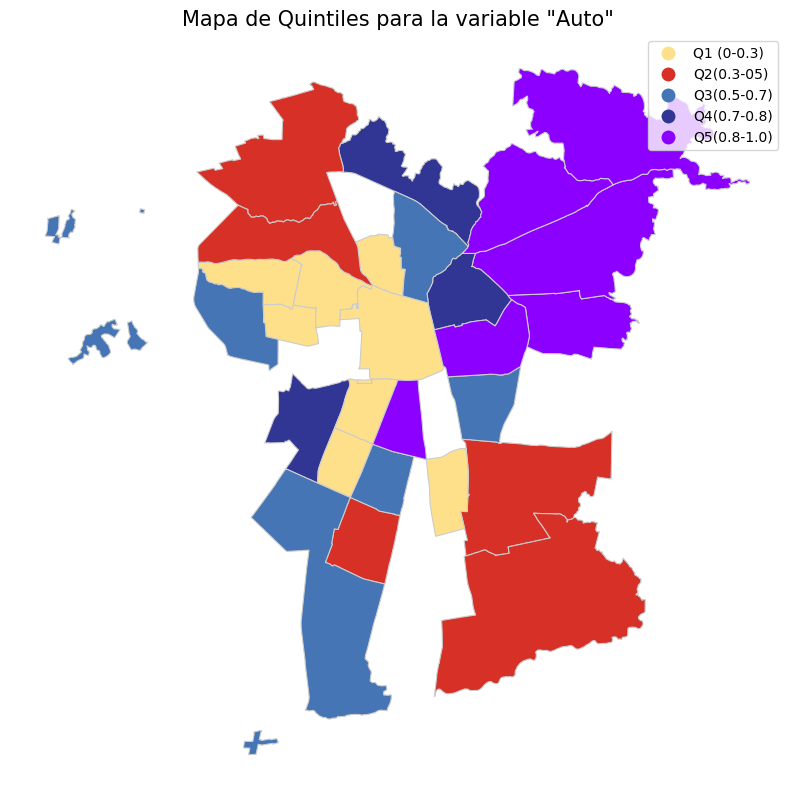

In [65]:
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import pandas as pd



quintiles = viajes_shp['Auto'].quantile([0, 0.3, 0.5, 0.7, 0.8, 1])

viajes_shp['Quintil'] = pd.cut(viajes_shp['Auto'], bins=quintiles, labels=['Q1 (0-0.3)', 'Q2(0.3-05)', 'Q3(0.5-0.7)', 'Q4(0.7-0.8)', 'Q5(0.8-1.0)'])

colors = ['#fee08b', '#d73027', '#4575b4', '#313695', '#8B00FF']

fig, ax = plt.subplots(1, 1, figsize=(10, 10))

viajes_shp.plot(column='Quintil', cmap=ListedColormap(colors), linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)

ax.set_title('Mapa de Quintiles para la variable "Auto"', fontdict={'fontsize': '15', 'fontweight': '3'})
ax.set_axis_off()
plt.show()
